# 6 - Additional Training Rounds<p>

In [1]:
from datasets import DatasetDict
ds_7 = DatasetDict.load_from_disk('pickles/7_labels_folder')
ds_20 = DatasetDict.load_from_disk('pickles/20_labels_folder')
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

I'm going to run additional rounds of training on both versions of the model (7 labels and 20 labels) to see how the performance improves, starting with the simplified 7 labels. Aside from changing the number of epochs, everything else is going to be the same. <p>
### 7 Labels

In [2]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model_7 = DistilBertForSequenceClassification.from_pretrained(model_name,num_labels=7)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def tokenize_7(batch):
    return tokenizer(batch['no_stopword'], return_tensors='pt', truncation=True, padding=True)

In [4]:
tokens_train_7 = ds_7['train'].map(tokenize_7, batched=True)
tokens_test_7 = ds_7['test'].map(tokenize_7, batched=True)

In [5]:
import evaluate
import numpy as np
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
from transformers import TrainingArguments, Trainer

In [6]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get the predicted class labels
    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    # Compute F1 score
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    # Return both metrics
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

Some research showed that for this model, training is often done with 3-4 rounds. I tried both, and found that there is the highest increase in performance at 3 epochs, but still some increase at four, which is what I have below. 

In [7]:
training_args_7 = TrainingArguments(
    output_dir='multistep_7',
    report_to='none',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4)

trainer_7 = Trainer(
   model=model_7,
   args=training_args_7,
   train_dataset=tokens_train_7,
   eval_dataset=tokens_test_7,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics)

In [8]:
trainer_7.train()

  0%|          | 0/2832 [00:00<?, ?it/s]

{'loss': 0.8508, 'grad_norm': 6.945952892303467, 'learning_rate': 1.6468926553672317e-05, 'epoch': 0.71}
{'loss': 0.5097, 'grad_norm': 10.3526029586792, 'learning_rate': 1.2937853107344633e-05, 'epoch': 1.41}
{'loss': 0.4101, 'grad_norm': 12.729840278625488, 'learning_rate': 9.40677966101695e-06, 'epoch': 2.12}
{'loss': 0.2954, 'grad_norm': 5.795869827270508, 'learning_rate': 5.8757062146892665e-06, 'epoch': 2.82}
{'loss': 0.238, 'grad_norm': 3.572582244873047, 'learning_rate': 2.344632768361582e-06, 'epoch': 3.53}
{'train_runtime': 1139.4358, 'train_samples_per_second': 39.718, 'train_steps_per_second': 2.485, 'train_loss': 0.43085842886887027, 'epoch': 4.0}


TrainOutput(global_step=2832, training_loss=0.43085842886887027, metrics={'train_runtime': 1139.4358, 'train_samples_per_second': 39.718, 'train_steps_per_second': 2.485, 'total_flos': 5995479150206976.0, 'train_loss': 0.43085842886887027, 'epoch': 4.0})

In [9]:
results_train_7 = trainer_7.evaluate(eval_dataset=tokens_train_7)
results_test_7 = trainer_7.evaluate(eval_dataset=tokens_test_7)

  0%|          | 0/708 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

In [10]:
print("Training Evaluation Results:", results_train_7)
print("Test Evaluation Results:", results_test_7)

Training Evaluation Results: {'eval_loss': 0.16409657895565033, 'eval_accuracy': 0.9481173767014318, 'eval_f1': 0.9482351012978927, 'eval_runtime': 99.2844, 'eval_samples_per_second': 113.955, 'eval_steps_per_second': 7.131, 'epoch': 4.0}
Test Evaluation Results: {'eval_loss': 0.6538137793540955, 'eval_accuracy': 0.8081518852894317, 'eval_f1': 0.8075501239315505, 'eval_runtime': 66.4836, 'eval_samples_per_second': 113.291, 'eval_steps_per_second': 7.084, 'epoch': 4.0}


Graphing the results:

In [11]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
texts_7 = ds_7['test']['no_stopword']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_7.to(device)
batch_size = 8

In [13]:
def predict_in_batches_7(texts, batch_size):
    predictions = []
    # Iterate over texts in smaller batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        
        # Tokenize the batch
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        
        # Move inputs to the same device as the model
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Make predictions
        with torch.no_grad():  # no need to compute gradients
            outputs = model_7(**inputs)

        # Get predicted classes
        logits = outputs.logits
        predicted_classes = torch.argmax(logits, dim=-1).cpu().numpy()
        
        predictions.extend(predicted_classes)

    return predictions

In [14]:
data_7 = pd.DataFrame(ds_7['test'])
predicted_7 = predict_in_batches_7(texts_7, batch_size)
data_7['predicted'] = predicted_7

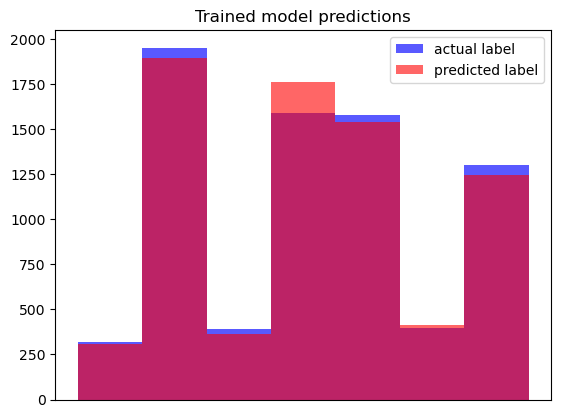

In [15]:
plt.hist(data_7['label'],bins=7,color='blue',alpha=0.65,label='actual label')
plt.hist(data_7['predicted'],bins=7,color='red',alpha=0.6,label='predicted label')
plt.legend()
plt.title('Trained model predictions')
plt.xticks([])

plt.savefig('charts/preds_multistep_7.png',bbox_inches='tight')

**Evals**:<br>
Training:<ul>
accuracy: 0.948<br>
f1: 0.948</ul>

Test:<ul>
accuracy: 0.808<br>
f1: 0.808</ul>

Random Chance:<ul>
accuracy/f1: 0.14

In [32]:
evals_7 = {'training':[0.948,0.948],'test':[0.808,0.808],'random chance':[0.14,0.14]}
metrics_7 = pd.DataFrame.from_dict(evals_7,orient='index',columns=['accuracy','f1'])
metrics_7

,accuracy,f1
training,0.948,0.948
test,0.808,0.808
random chance,0.140,0.140


**Loss values**:<ul>
trainer 1: 0.851<br>
trainer 2: 0.510<br>
trainer 3: 0.410<br>
trainer 4: 0.295<br>
trainer 5: 0.238<br>
train_loss: 0.431<br>
eval_train: 0.164<br>
eval_test: 0.654<br>
chance: 1.95

In [33]:
values_7 = {'trainer1':[0.851],'trainer2':[0.510],'trainer3':[0.410],'trainer4':[0.295], 'trainer5':[0.238], 'train_loss':[0.431],'eval_train':[0.164],'eval_test':[0.654],'chance':[1.95]}
losses_7 = pd.DataFrame.from_dict(values_7,orient='index',columns=['loss'])
losses_7

,loss
trainer1,0.851
trainer2,0.510
trainer3,0.410
trainer4,0.295
trainer5,0.238
train_loss,0.431
eval_train,0.164
eval_test,0.654
chance,1.950


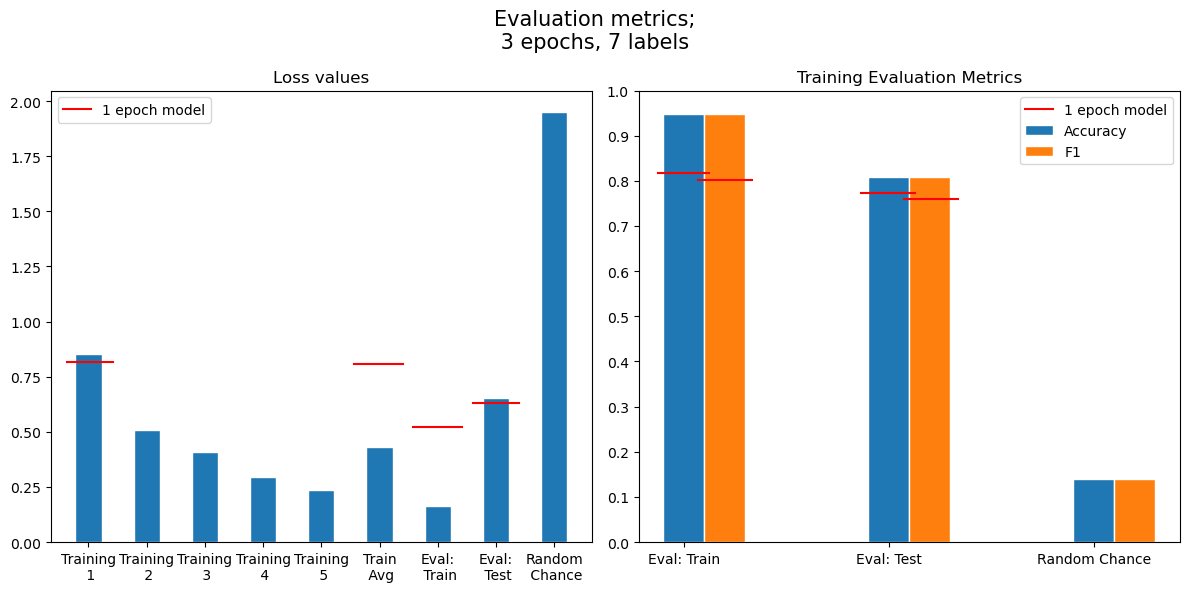

In [50]:
# for 1st chart
b_width1 = 0.45
bar_1 = losses_7['loss']
x_1 = np.arange(len(bar_1))

# for 2nd chart
b_width2 = 0.2
bar1 = metrics_7['accuracy']
bar2 = metrics_7['f1']
x1 = np.arange(len(bar1))
x2 = x1 + b_width2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# 1st chart
ax1.bar(x_1,bar_1,width=b_width1, edgecolor='white')
ax1.axhline(y=0.818,xmin=0.03,xmax=0.115,color='red',label='1 epoch model')
ax1.axhline(y=0.806,xmin=0.56,xmax=0.65,color='red')
ax1.axhline(y=0.521,xmin=0.67,xmax=0.76,color='red')
ax1.axhline(y=0.632,xmin=0.78,xmax=0.865,color='red')
ax1.set_xticks(x_1)
ax1.set_xticks(x_1)
ax1.set_xticklabels(['Training\n 1', 'Training\n 2', 'Training\n 3', 'Training\n 4', 'Training\n 5', 'Train\n Avg', 'Eval:\n Train', 'Eval:\n Test', 'Random\n Chance'])
ax1.set_title('Loss values')
ax1.legend()

# 2nd chart
ax2.bar(x1,bar1,width=b_width2,edgecolor='white',label='Accuracy')
ax2.bar(x2,bar2,width=b_width2,edgecolor='white',label='F1')
ax2.axhline(y=0.818,xmin=0.035,xmax=0.13,color='red',label='1 epoch model')
ax2.axhline(y=0.802,xmin=0.11,xmax=0.21,color='red')
ax2.axhline(y=0.774,xmin=0.41,xmax=0.51,color='red')
ax2.axhline(y=0.759,xmin=0.49,xmax=0.59,color='red')
ax2.set_xticks(x1)
ax2.set_xticklabels(['Eval: Train', 'Eval: Test', 'Random Chance'])
ax2.legend()
ax2.set_yticks(np.arange(0,1.1,0.1))
ax2.set_title('Training Evaluation Metrics')

plt.suptitle('Evaluation metrics;\n 3 epochs, 7 labels ',fontsize=15)
plt.tight_layout()

plt.savefig('charts/evals_multistep_7.png',bbox_inches='tight')

|Loss Value |1 Epoch|4 Epochs|Change|
|-----------|------:|-------:|-----:|
|Train Avg  |  0.806|   0.431|-0.375|
|Eval: Train|  0.521|   0.164|-0.357|
|Eval: Test |  0.632|   0.654|+0.022|
<p>

|Accuracy   |1 Epoch|4 Epochs|Change|
|-----------|------:|-------:|-----:|
|Eval: Train|  0.818|   0.948|+0.130|
|Eval: Test |  0.774|   0.808|+0.034|
<p>

|F1         |1 Epoch|4 Epochs|Change|
|-----------|------:|-------:|-----:|
|Eval: Train|  0.802|   0.948|+0.146|
|Eval: Test |  0.759|   0.808|+0.049|

The fact that there is such a drop from the train to test implies some kind of overfitting, but the model's performance has still improved.<p>
Repeat this process for the 20 labels model, and see if the same thing happens. <p>
### 20 Labels

In [19]:
model_20 = DistilBertForSequenceClassification.from_pretrained(model_name,num_labels=20)

def tokenize_20(batch):
    return tokenizer(batch['processed'], return_tensors='pt', truncation=True, padding=True)

tokens_train_20 = ds_20['train'].map(tokenize_20, batched=True)
tokens_test_20 = ds_20['test'].map(tokenize_20, batched=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
training_args_20 = TrainingArguments(
    output_dir='multistep_20',
    report_to='none',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4)

trainer_20 = Trainer(
   model=model_20,
   args=training_args_20,
   train_dataset=tokens_train_20,
   eval_dataset=tokens_test_20,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics)

In [21]:
trainer_20.train()

  0%|          | 0/2832 [00:00<?, ?it/s]

{'loss': 1.8727, 'grad_norm': 8.483327865600586, 'learning_rate': 1.6468926553672317e-05, 'epoch': 0.71}
{'loss': 1.0541, 'grad_norm': 6.4842939376831055, 'learning_rate': 1.2937853107344633e-05, 'epoch': 1.41}
{'loss': 0.8627, 'grad_norm': 9.605780601501465, 'learning_rate': 9.40677966101695e-06, 'epoch': 2.12}
{'loss': 0.6783, 'grad_norm': 9.449655532836914, 'learning_rate': 5.8757062146892665e-06, 'epoch': 2.82}
{'loss': 0.5884, 'grad_norm': 13.316062927246094, 'learning_rate': 2.344632768361582e-06, 'epoch': 3.53}
{'train_runtime': 3249.0648, 'train_samples_per_second': 13.929, 'train_steps_per_second': 0.872, 'train_loss': 0.9555027309784108, 'epoch': 4.0}


TrainOutput(global_step=2832, training_loss=0.9555027309784108, metrics={'train_runtime': 3249.0648, 'train_samples_per_second': 13.929, 'train_steps_per_second': 0.872, 'total_flos': 5996868997447680.0, 'train_loss': 0.9555027309784108, 'epoch': 4.0})

In [22]:
results_train_20 = trainer_20.evaluate(eval_dataset=tokens_train_20)
results_test_20 = trainer_20.evaluate(eval_dataset=tokens_test_20)

  0%|          | 0/708 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

In [23]:
print("Training Evaluation Results:", results_train_20)
print("Test Evaluation Results:", results_test_20)

Training Evaluation Results: {'eval_loss': 0.4547242224216461, 'eval_accuracy': 0.8725472865476401, 'eval_f1': 0.8710519490841062, 'eval_runtime': 178.5355, 'eval_samples_per_second': 63.371, 'eval_steps_per_second': 3.966, 'epoch': 4.0}
Test Evaluation Results: {'eval_loss': 1.0819001197814941, 'eval_accuracy': 0.6903876792352629, 'eval_f1': 0.6878910333935101, 'eval_runtime': 121.308, 'eval_samples_per_second': 62.09, 'eval_steps_per_second': 3.883, 'epoch': 4.0}


Graphing:

In [24]:
texts_20 = ds_20['test']['processed']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_20.to(device)
batch_size = 8

In [25]:
def predict_in_batches_20(texts, batch_size):
    predictions = []
    # Iterate over texts in smaller batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        
        # Tokenize the batch
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        
        # Move inputs to the same device as the model
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Make predictions
        with torch.no_grad():  # no need to compute gradients
            outputs = model_20(**inputs)

        # Get predicted classes
        logits = outputs.logits
        predicted_classes = torch.argmax(logits, dim=-1).cpu().numpy()
        
        predictions.extend(predicted_classes)

    return predictions

In [26]:
data_20 = pd.DataFrame(ds_20['test'])
predicted_20 = predict_in_batches_20(texts_20, batch_size)
data_20['predicted'] = predicted_20

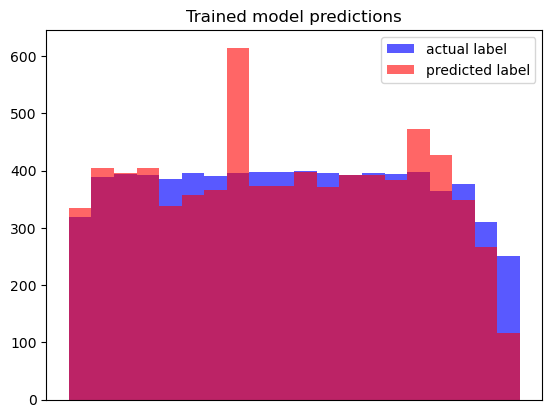

In [27]:
plt.hist(data_20['label'],bins=20,color='blue',alpha=0.65,label='actual label')
plt.hist(data_20['predicted'],bins=20,color='red',alpha=0.6,label='predicted label')
plt.legend()
plt.title('Trained model predictions')
plt.xticks([])

plt.savefig('charts/preds_multistep_20.png',bbox_inches='tight')

**Evals**:<br>
Training:<ul>
accuracy: 0.873<br>
f1: 0.871</ul>

Test:<ul>
accuracy: 0.690<br>
f1: 0.688</ul>

Random Chance:<ul>
accuracy/f1: 0.05

In [36]:
evals_20 = {'training':[0.873,0.871],'test':[0.69,0.688],'random chance':[0.05,0.05]}
metrics_20 = pd.DataFrame.from_dict(evals_20,orient='index',columns=['accuracy','f1'])
metrics_20

,accuracy,f1
training,0.873,0.871
test,0.690,0.688
random chance,0.050,0.050


**Loss values**:<ul>
trainer 1: 1.873<br>
trainer 2: 1.054<br>
trainer 3: 0.863<br>
trainer 4: 0.678<br>
trainer 5: 0.588<br>
train_loss: 0.956<br>
eval_train: 0.455<br>
eval_test: 1.082<br>
chance: 2.996

In [37]:
values_20 = {'trainer1':[1.873],'trainer2':[1.054],'trainer3':[0.863],'trainer4':[0.678],'trainer5':[0.588],'train_loss':[0.956],'eval_train':[0.455],'eval_test':[1.082],'chance':[2.996]}
losses_20 = pd.DataFrame.from_dict(values_20,orient='index',columns=['loss'])
losses_20

,loss
trainer1,1.873
trainer2,1.054
trainer3,0.863
trainer4,0.678
trainer5,0.588
train_loss,0.956
eval_train,0.455
eval_test,1.082
chance,2.996


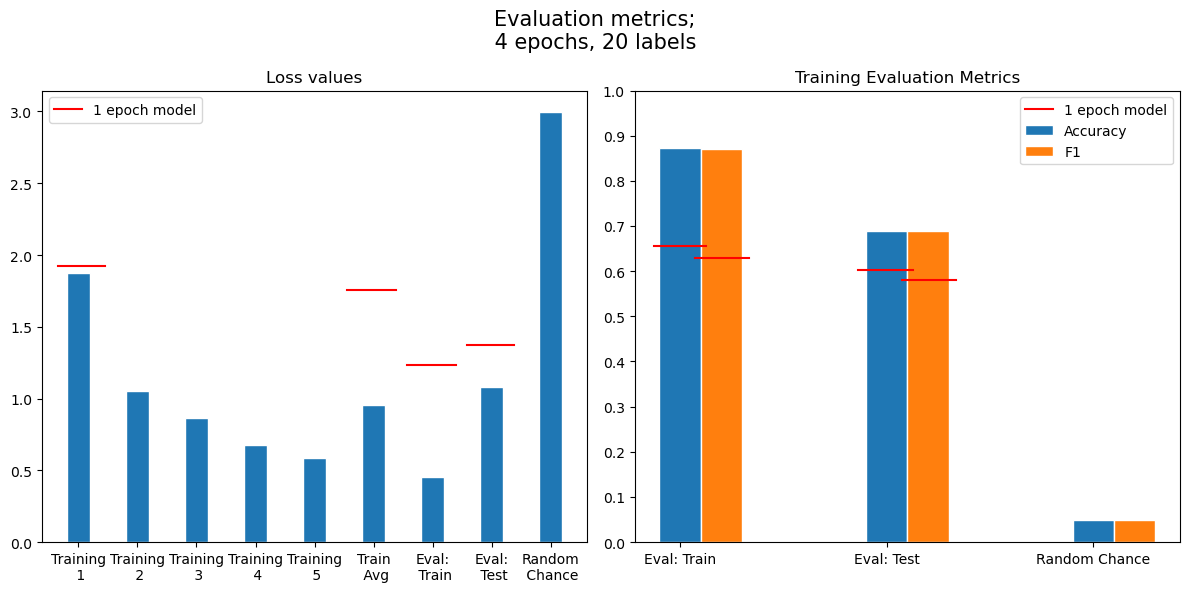

In [51]:
# for 1st chart
b_width1 = 0.4
bar_1 = losses_20['loss']
x_1 = np.arange(len(bar_1))

# for 2nd chart
b_width2 = 0.2
bar1 = metrics_20['accuracy']
bar2 = metrics_20['f1']
x1 = np.arange(len(bar1))
x2 = x1 + b_width2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# 1st chart
ax1.bar(x_1,bar_1,width=b_width1, edgecolor='white')
ax1.axhline(y=1.922,xmin=0.03,xmax=0.115,color='red',label='1 epoch model')
ax1.axhline(y=1.758,xmin=0.56,xmax=0.65,color='red')
ax1.axhline(y=1.234,xmin=0.67,xmax=0.76,color='red')
ax1.axhline(y=1.374,xmin=0.78,xmax=0.865,color='red')
ax1.set_xticks(x_1)
ax1.set_xticks(x_1)
ax1.set_xticklabels(['Training\n 1', 'Training\n 2', 'Training\n 3', 'Training\n 4', 'Training\n 5', 'Train\n Avg', 'Eval:\n Train', 'Eval:\n Test', 'Random\n Chance'])
ax1.set_title('Loss values')
ax1.legend()

# 2nd chart
ax2.bar(x1,bar1,width=b_width2,edgecolor='white',label='Accuracy')
ax2.bar(x2,bar2,width=b_width2,edgecolor='white',label='F1')
ax2.axhline(y=0.656,xmin=0.035,xmax=0.13,color='red',label='1 epoch model')
ax2.axhline(y=0.63,xmin=0.11,xmax=0.21,color='red')
ax2.axhline(y=0.603,xmin=0.41,xmax=0.51,color='red')
ax2.axhline(y=0.58,xmin=0.49,xmax=0.59,color='red')
ax2.set_xticks(x1)
ax2.set_xticklabels(['Eval: Train', 'Eval: Test', 'Random Chance'])
ax2.legend()
ax2.set_yticks(np.arange(0,1.1,0.1))
ax2.set_title('Training Evaluation Metrics')

plt.suptitle('Evaluation metrics;\n 4 epochs, 20 labels ',fontsize=15)
plt.tight_layout()

plt.savefig('charts/evals_multistep_20.png',bbox_inches='tight')

|Loss Value |1 Epoch|4 Epochs|Change|
|-----------|------:|-------:|-----:|
|Train Avg  |  1.758|   0.956|-0.802|
|Eval: Train|  1.234|   0.455|-0.779|
|Eval: Test |  1.374|   1.082|-0.292|
<p>

|Accuracy   |1 Epoch|4 Epochs|Change|
|-----------|------:|-------:|-----:|
|Eval: Train|  0.656|   0.873|+0.217|
|Eval: Test |  0.603|   0.690|+0.087|
<p>

|F1         |1 Epoch|4 Epochs|Change|
|-----------|------:|-------:|-----:|
|Eval: Train|  0.630|   0.871|+0.241|
|Eval: Test |  0.603|   0.688|+0.085|

The same dramatic drop from train to test occurs here too, so additional hyperparameters are likely needed to control for that. 